In [115]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import seaborn as sns
import scipy

In [131]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times New Roman']})
# rc('text', usetex=True)

In [132]:
test_video = 'data/stabilized_video.mp4'
print(os.path.isfile(test_video))

True


In [133]:
def vid_to_ndarray(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

In [134]:
test_array = vid_to_ndarray(test_video)
print(test_array.shape)

(1414, 300, 300, 3)


In [135]:
cv_channels = {'b': 0, 'g': 1, 'r': 2}
test_array_green = test_array[:, :, :, cv_channels['g']]
test_array_red = test_array[:, :, :, cv_channels['r']]
test_array_blue = test_array[:, :, :, cv_channels['b']]
print(test_array_green.shape)

(1414, 300, 300)


In [136]:
def resize_mean(array, size):
    t, h, w = array.shape
    h_new, w_new = h//size, w//size
    flattened = np.reshape(array, (t, h_new, size, w_new, size)).swapaxes(2, 3).reshape(t, h_new, w_new, size**2)
    return flattened.mean(axis=-1)

In [137]:
def resize_arbitrary(f, array, size):
    t, h, w = array.shape
    h_new, w_new = h//size, w//size
    flattened = np.reshape(array, (t, h_new, size, w_new, size)).swapaxes(2, 3).reshape(t, h_new, w_new, size**2)
    return f(flattened, axis=-1)

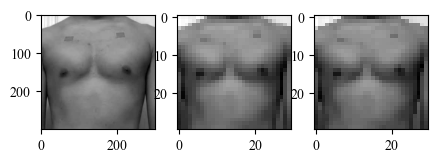

In [138]:
test_array_mean_resize = resize_mean(test_array_green, 10)
test_array_median_resize = resize_arbitrary(np.median, test_array_green, 10)

fig, ax = plt.subplots(1, 3, figsize=(5, 5))
ax[0].imshow(test_array_green[0], cmap='gray')
ax[1].imshow(test_array_mean_resize[0], cmap='gray')
ax[2].imshow(test_array_median_resize[1], cmap='gray')
plt.show()

In [139]:
block_size = 30

n_frames = test_array_green.shape[0]
green_signals = resize_mean(test_array_green, block_size).reshape(n_frames, -1).swapaxes(0, 1)
red_signals = resize_mean(test_array_red, block_size).reshape(n_frames, -1).swapaxes(0, 1)
blue_signals = resize_mean(test_array_blue, block_size).reshape(n_frames, -1).swapaxes(0, 1)
print(green_signals.shape)

(100, 1414)


In [140]:
gs, rs, bs = green_signals[50], red_signals[50], blue_signals[50]

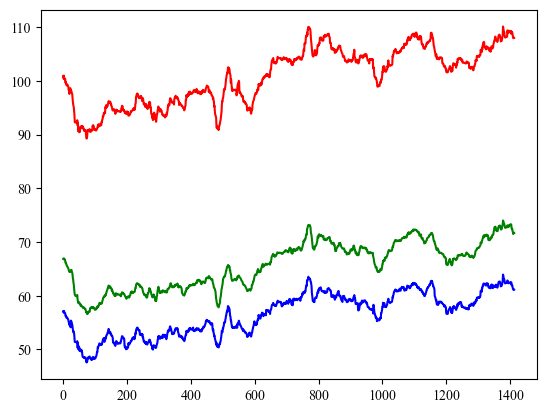

In [141]:
plt.figure()
plt.plot(gs, color='g')
plt.plot(rs, color='r')
plt.plot(bs, color='b')
plt.show()

In [142]:
rgb_mean = (rs + gs + bs) / 3
Rn, Gn, Bn = rs/rgb_mean, gs/rgb_mean, bs/rgb_mean

Xs = 3*Rn - 2*Gn
Ys = 1.5*Rn + Gn - 1.5*Bn

In [143]:
cap = cv2.VideoCapture(test_video)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

low_freq = 40/60
high_freq = 240/60

iirb, iira = scipy.signal.butter(3, ((2*low_freq)/fps, (2*high_freq)/fps), 'bandpass')

Xf = scipy.signal.filtfilt(iirb, iira, Xs)
Yf = scipy.signal.filtfilt(iirb, iira, Ys)

In [162]:
alpha = np.std(Xf) / np.std(Yf)
S = Xf - alpha*Yf
S_fft = np.abs(np.fft.rfft(S))
S_fft = S_fft[:200]
print(np.argmax(S_fft))

47


C:\Users\Tienda\AppData\Local\Temp\ipykernel_31700\4104932493.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


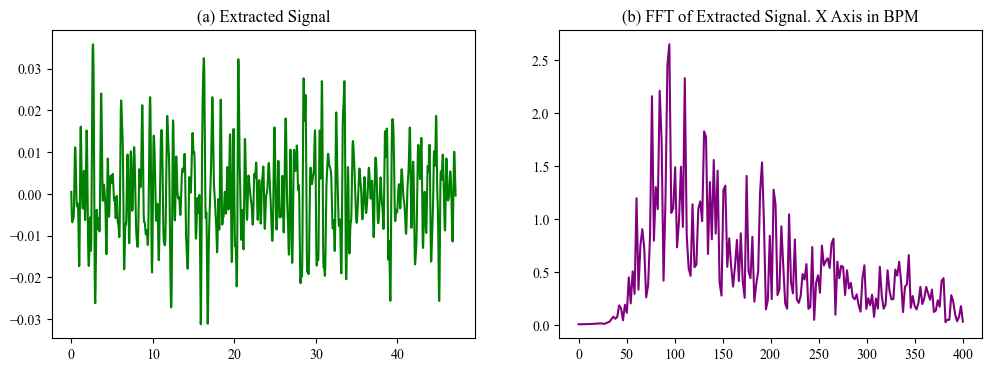

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('(a) Extracted Signal')
ax[0].plot(np.linspace(0, len(S)/30, len(S)), S, color='g')
ax[1].set_title('(b) FFT of Extracted Signal. X Axis in BPM')
ax[1].plot(np.linspace(0, 60 * len(S_fft)/30, len(S_fft)), S_fft, color='purple')
fig.savefig('images/extracted_signal.png', bbox_inches='tight')
fig.show()